In [169]:
from display_utils import getHeader

<div style="font-size: 30px"><b>Data Sources</b></div>

<b>1.</b> This project uses the Global Landslide Catalog dataset exported from the NASA's Open Data Portal https://data.nasa.gov/Earth-Science/Global-Landslide-Catalog-Export/dd9e-wu2v/about_data

As required by the host page, we cite the following two sources

<i>Kirschbaum, D. B., Adler, R., Hong, Y., Hill, S., & Lerner-Lam, A. (2010). A global landslide catalog for hazard applications: method, results, and limitations. Natural Hazards, 52(3), 561–575. doi:10.1007/s11069-009-9401-4. [1]</i>

<i>Kirschbaum, D.B., T. Stanley, Y. Zhou (In press, 2015). Spatial and Temporal Analysis of a Global Landslide Catalog. Geomorphology. doi:10.1016/j.geomorph.2015.03.016. [2]</i>

<b>2.</b> We will also use the GDP by country dataset obtained from https://github.com/datasets/gdp/blob/master/data/gdp.csv.


<div style="font-size: 30px"><b>Project Objectives</b></div>

<div style="font-size: 20px">We would like to understand the relationship between <b>casualties</b> (as defined below) and other variables from the datesets such as event time and country GDP in landslide events. We will use explorative data analysis and build interpretable regression models toward this goal.</div> 

<div style="border: 1px solid lightgrey; width: 80%"></div>

<div style="font-size: 30px"><b>Explorative Data Analysis</b></div>

In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [171]:
landslide_data = pd.read_csv('landslide_data.csv')

In [172]:
landslide_data.shape

(11033, 31)

<div style="font-size: 25px"><b>Data Cleaning and Formatting</b></div>

<div style="font-size: 20px"><b>Global Landslide Dataset</b></div>
We will start with the global landslide dataset

<div style="border: 1px solid lightgrey; width: 80%"></div>

<div style="font-size: 15px"><b>Convert event_date to pd.datetime</b></div>

In [173]:
landslide_data['timestamp'] = pd.to_datetime(landslide_data['event_date'], format='%m/%d/%Y %H:%M:%S %p')

This contains the event time. We will drop other columns that contain this information.

In [174]:
landslide_data = landslide_data.drop(['event_date', 'event_time'], axis=1)

In [175]:
landslide_data.shape

(11033, 30)

<div style="font-size: 15px"><b>Add event_source column</b></div>

In [176]:
landslide_data['source_name'].nunique()

3918

In [177]:
source_name_count_df = landslide_data.groupby(['source_name']).size().sort_values(ascending=False).reset_index(name="count")
source_name_count_df.head(10)

,source_name,count
0,Oregon DOT,768
1,maps.google.com,104
2,thehimalayantimes,75
3,news.xinhuanet,74
4,newsinfo.inquirer,71
5,thejakartapost,59
6,ibnlive.in,57
7,Times of India,47
8,The Jakarta Post,46
9,The Himalayan Times,43


We will take only the 15 source_name's and create a new group 'others' for the rest

In [178]:
major_sources = set(source_name_count_df['source_name'].iloc[:15])

In [179]:
def getEventSource(row):
    source = 'Others'
    if row['source_name'] in major_sources:
        source = row['source_name']
    row['event_source'] = source
    return row
landslide_data = landslide_data.apply(getEventSource, axis=1)

In [180]:
landslide_data['event_source'] = landslide_data['event_source'].astype('category')

In [181]:
landslide_data[landslide_data['source_name'] == 'maps.google.com'].head(2)

,source_name,source_link,event_id,event_title,event_description,location_description,location_accuracy,landslide_category,landslide_trigger,landslide_size,...,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude,timestamp,event_source
495,maps.google.com,http://maps.google.com.br/maps/ms?source=embed...,1680,"Rua Ceará, bairro Quitandinha",Rua Ceará - bairro Quitandinha Deslizamento c...,"Rua Ceará, bairro Quitandinha",exact,landslide,downpour,medium,...,272691.0,Petrópolis,4.82307,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-43.2212,-22.5232,2010-04-06 12:00:00,maps.google.com
517,maps.google.com,http://maps.google.com.br/maps/ms?source=embed...,1633,Morro da Mangueira,O mapa da devastação no Rio. Queda de barreir...,Morro da Mangueira,1km,mudslide,downpour,medium,...,6023699.0,Rio de Janeiro,3.27331,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-43.2394,-22.9033,2010-04-06 12:00:00,maps.google.com


We will drop source_name and source_link. The information from these two columns are represented in event_source.

In [182]:
landslide_data = landslide_data.drop(['source_name', 'source_link'], axis=1)


In [183]:
landslide_data.shape

(11033, 29)

<div style="font-size: 15px"><b>Landslide description with categorical variables</b> <span>(contain missing values. We will deal with them separately, see details below)</span></div>

We will convert a few variables that classify the landslide events in groups into categorical variables

In [184]:
landslide_info_categoricals = ['landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting']

<b>Missing values</b>
<div>We will delete rows with missing values for landslide_category and landslide_size. For landslide_trigger, we will create a new group 'unknown' for the missing values. For landslide_setting, since there is already a class "unknown", we assign this value to the rows with missing landslide_setting.</div>

In [185]:
landslide_data[['landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting']].isna().sum()

landslide_category     1
landslide_trigger     23
landslide_size         9
landslide_setting     69
dtype: int64

In [186]:
landslide_data = landslide_data.dropna(subset = ['landslide_category'])

In [187]:
landslide_data = landslide_data.dropna(subset = ['landslide_size'])

In [188]:
landslide_data.loc[landslide_data['landslide_trigger'].isna(), 'landslide_trigger'] = 'unknown'

In [189]:
landslide_data.loc[landslide_data['landslide_setting'].isna(), 'landslide_setting'] = 'unknown'

In [190]:
landslide_data[['landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting']].isna().sum()

landslide_category    0
landslide_trigger     0
landslide_size        0
landslide_setting     0
dtype: int64

In [191]:
for column in landslide_info_categoricals:
    landslide_data[column] = landslide_data[column].astype('category')

<div style="font-size: 15px"><b>fatality_count</b></div>

In [192]:
landslide_data[['fatality_count']].isna().sum()

fatality_count    1383
dtype: int64

In [193]:
landslide_data = landslide_data.dropna(subset = ['fatality_count'])

landslide_data['fatality_count'].describe()

<Axes: xlabel='fatality_count', ylabel='Density'>

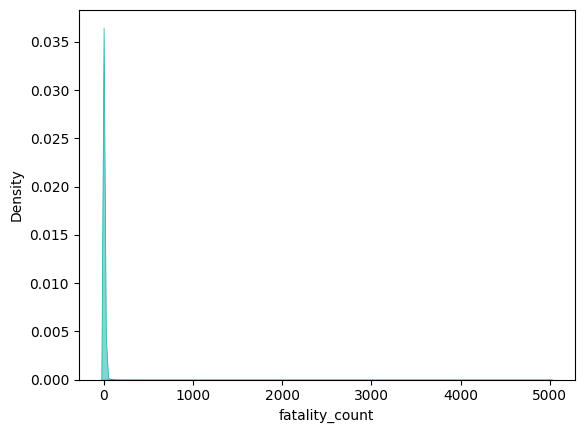

In [194]:
fig, ax = plt.subplots()
sns.kdeplot(landslide_data['fatality_count'], ax=ax, fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

There are outliers to the right having extremely big values. This skews the distribution. 

In [195]:
landslide_data[landslide_data['fatality_count'] > 1000].size

87

In [196]:
landslide_data_without_outliers = landslide_data[np.abs(landslide_data["fatality_count"]-landslide_data["fatality_count"].mean())<=(3*landslide_data["fatality_count"].std())] 

In [214]:
landslide_data['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)

In [215]:
landslide_data.columns

Index(['timestamp', 'event_source', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'country_code', 'longitude', 'latitude', 'log_fatality_count'],
      dtype='object')

In [217]:
landslide_data_without_outliers['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)

<Axes: xlabel='log_fatality_count', ylabel='Density'>

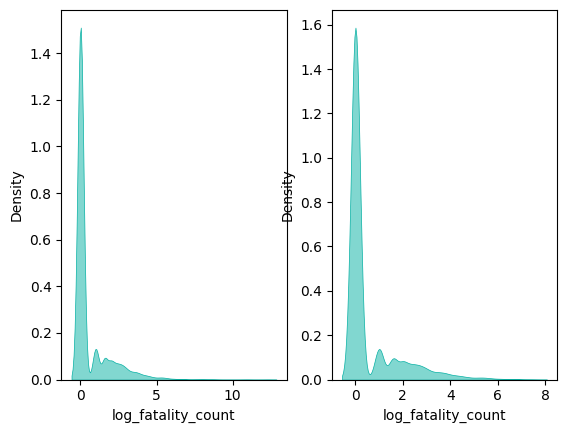

In [219]:
fig, axes = plt.subplots(ncols=2, nrows=1)
sns.kdeplot(landslide_data['log_fatality_count'], ax=axes[0], fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')
sns.kdeplot(landslide_data_without_outliers['log_fatality_count'], ax=axes[1], fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

In [212]:
landslide_data.shape
# landslide_data_without_outliers['log_fatality_count'] = np.log2(landslide_data['fatality_count'] + 1)

(9640, 11)

In [200]:
# fig, ax = plt.subplots()
# sns.kdeplot(landslide_data_without_outliers['log_fatality_count'], ax=ax, fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3')

<div style="font-size: 15px"><b>Select Columns to Use</b></div>
We will select columns that seem correlated with the target fatality_count

In [201]:
used_columns = ['timestamp', 'event_source', 'landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting', 'log_fatality_count', 'injury_count', 'country_code', 'longitude', 'latitude']

In [202]:
landslide_data = landslide_data[used_columns]
landslide_data_without_outliers = landslide_data_without_outliers[used_columns]

In [203]:
landslide_data.shape

(9640, 11)

<div style="font-size: 15px"><b>Missing Values</b></div>
We have dealt some missing values above. In this section, we will look at other columns that contain missing values.

In [222]:
landslide_data.isna().sum()

timestamp                0
event_source             0
landslide_category       0
landslide_trigger        0
landslide_size           0
landslide_setting        0
fatality_count           0
injury_count          4297
country_code          1510
longitude                0
latitude                 0
log_fatality_count       0
dtype: int64

<div style="font-size: 12px"><b>1. injury_count missing values - Impute class average</b></div>
For injury_count, we will divide the input points that have injury_count into 4 classes based on the quantiles of fatality_count. Then we will compute the average injury_count in those classes and impute the missing values with the average corresponding to the class the row's fatality_count belongs to.

In [260]:
fatality_quantiles = landslide_data['fatality_count'].quantile([0, 0.9, 0.95, 0.99, 1])
fatality_quantiles = fatality_quantiles.to_list()

In [261]:
def compute_fatality_class(row):
    count = row['fatality_count']
    if count <= fatality_quantiles[1]:
        row['fatality_class'] = 0
    elif fatality_quantiles[1] < count <= fatality_quantiles[2]:
        row['fatality_class'] = 1
    elif fatality_quantiles[2] < count <= fatality_quantiles[3]:
        row['fatality_class'] = 2
    else:
        row['fatality_class'] = 3
    return row
landslide_data = landslide_data.apply(compute_fatality_class, axis=1)

In [262]:
landslide_injury_count = landslide_data[landslide_data['injury_count'].notna()]

In [263]:
fatality_count_by_class = landslide_injury_count.groupby('fatality_class')['injury_count'].mean()

In [264]:
fatality_count_by_class = fatality_count_by_class.to_dict()

In [266]:
def impute_injury_count(row):
    fatality_class = row['fatality_class']
    if pd.isna(row['injury_count']):
        row['injury_count'] = fatality_count_by_class[fatality_class]
    return row
    

landslide_data = landslide_data.apply(impute_injury_count, axis=1)

<div style="font-size: 12px"><b>2. country_code missing values - create new class unknown</b></div>
For missing country_code values, we will create a new class unknown.

In [273]:
def assign_missing_country_code(row):
    if pd.isna(row['country_code']):
        row['country_code'] = 'unknown'
    return row
landslide_data = landslide_data.apply(assign_missing_country_code, axis=1)

<div style="font-size: 20px"><b>Country GDP Dataset</b></div>
We will now turn to the country GDP dataset

<div style="border: 1px solid lightgrey; width: 80%"></div>

In [276]:
gdp_data = pd.read_csv('gdp.csv')

In [279]:
landslide_data['year'] = landslide_data['timestamp'].dt.year

dtype('int64')

In [288]:
df = landslide_data.merge(gdp_data, left_on=['country_code', 'year'], right_on=['Country Code', 'Year'], how='left' )

In [290]:
landslide_data.iloc[0][['year', 'country_code']]

year            2008
country_code      CN
Name: 0, dtype: object

In [295]:
gdp_data['Country Code'].describe()

count     11507
unique      256
top         HKG
freq         57
Name: Country Code, dtype: object